# Cardio Vascular disease multi class prediction

notebook นี้เป็นการ optimized multiclass classification จาก [paper](https://arxiv.org/abs/2203.04921) ซึ่งวิธีหลักที่ใช้ในการเพิ่มประสิทธิภาพคือ

1.   เรามี data ที่ enrich กว่ามาก จาก paper ใช้ไปแค่ 300 entries / เรามี 920 entries ทำให้โมเดล generalized ได้ดีกว่า
2.   data preprocessing มีความละเอียดกว่าใน paper มากซึ่งจะมี pipeline คือ rawdata->EDA->missingvalue->Impute(classinbalance)->feature engineering->outlier->encoding->scaling

Note:

1.   ผลที่ได้มีความต่างจาก paper เล็กน้อย คือ accuracy 75% -> 77%
3. Evaluation method ของเราใช้วิธีเดียวกับ paper คือ 80:20 split เพื่อให้เทียบผลกันได้



#Setup

In [1]:
# @title Lib initiation
# Importing Libararies
# To Handle Data
import pandas as pd
import numpy as np
# To visualize the Data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# for Data Peprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer,KNNImputer
# Import Iterative Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Machine Learning
from sklearn.model_selection import train_test_split
# For Classification tasks
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,RandomForestRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
# metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Multi classes CVD

## data preparation

In [2]:
df = pd.read_csv("/content/heart_disease_uci.csv")
cat_cols=['sex','dataset','cp','fbs','restecg','exang','slope','thal','trestbps_bins','num_bins']
bool_cols=['fbs','exang']
numeric_cols=['id','age','trestbps','chol','thalch','oldpeak','ca','num']

In [53]:
df['num'].value_counts()

,count
num,
0,411
1,265
2,109
3,106
4,28


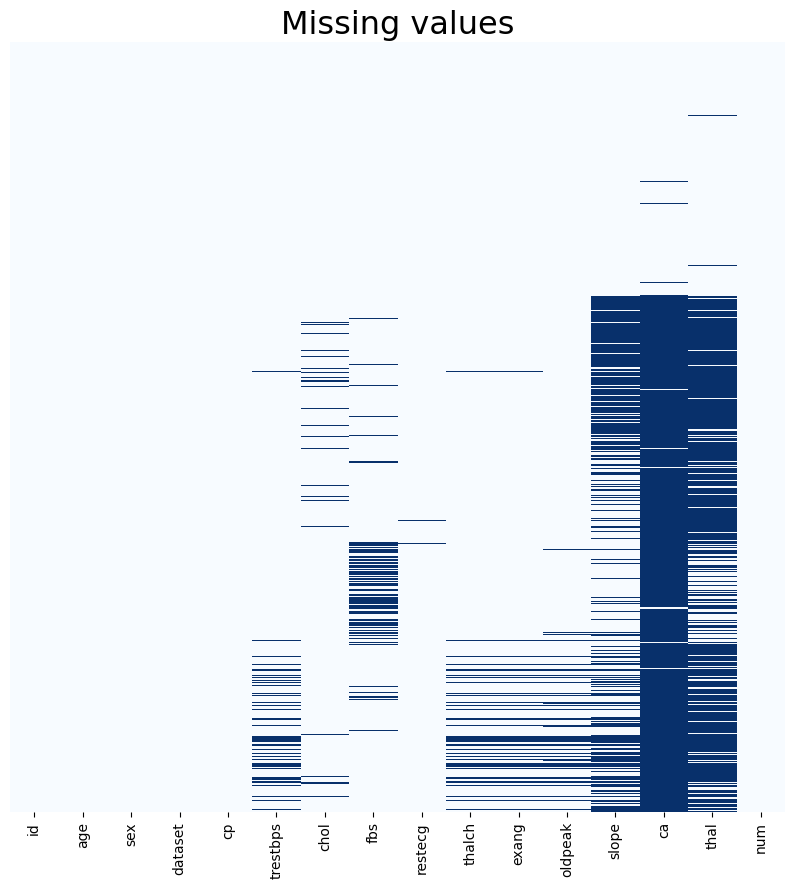

In [3]:
# create heatmap to check missing values after imputation
plt.figure(figsize=(10, 10))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='Blues')
plt.title('Missing values', size=23)
plt.show()

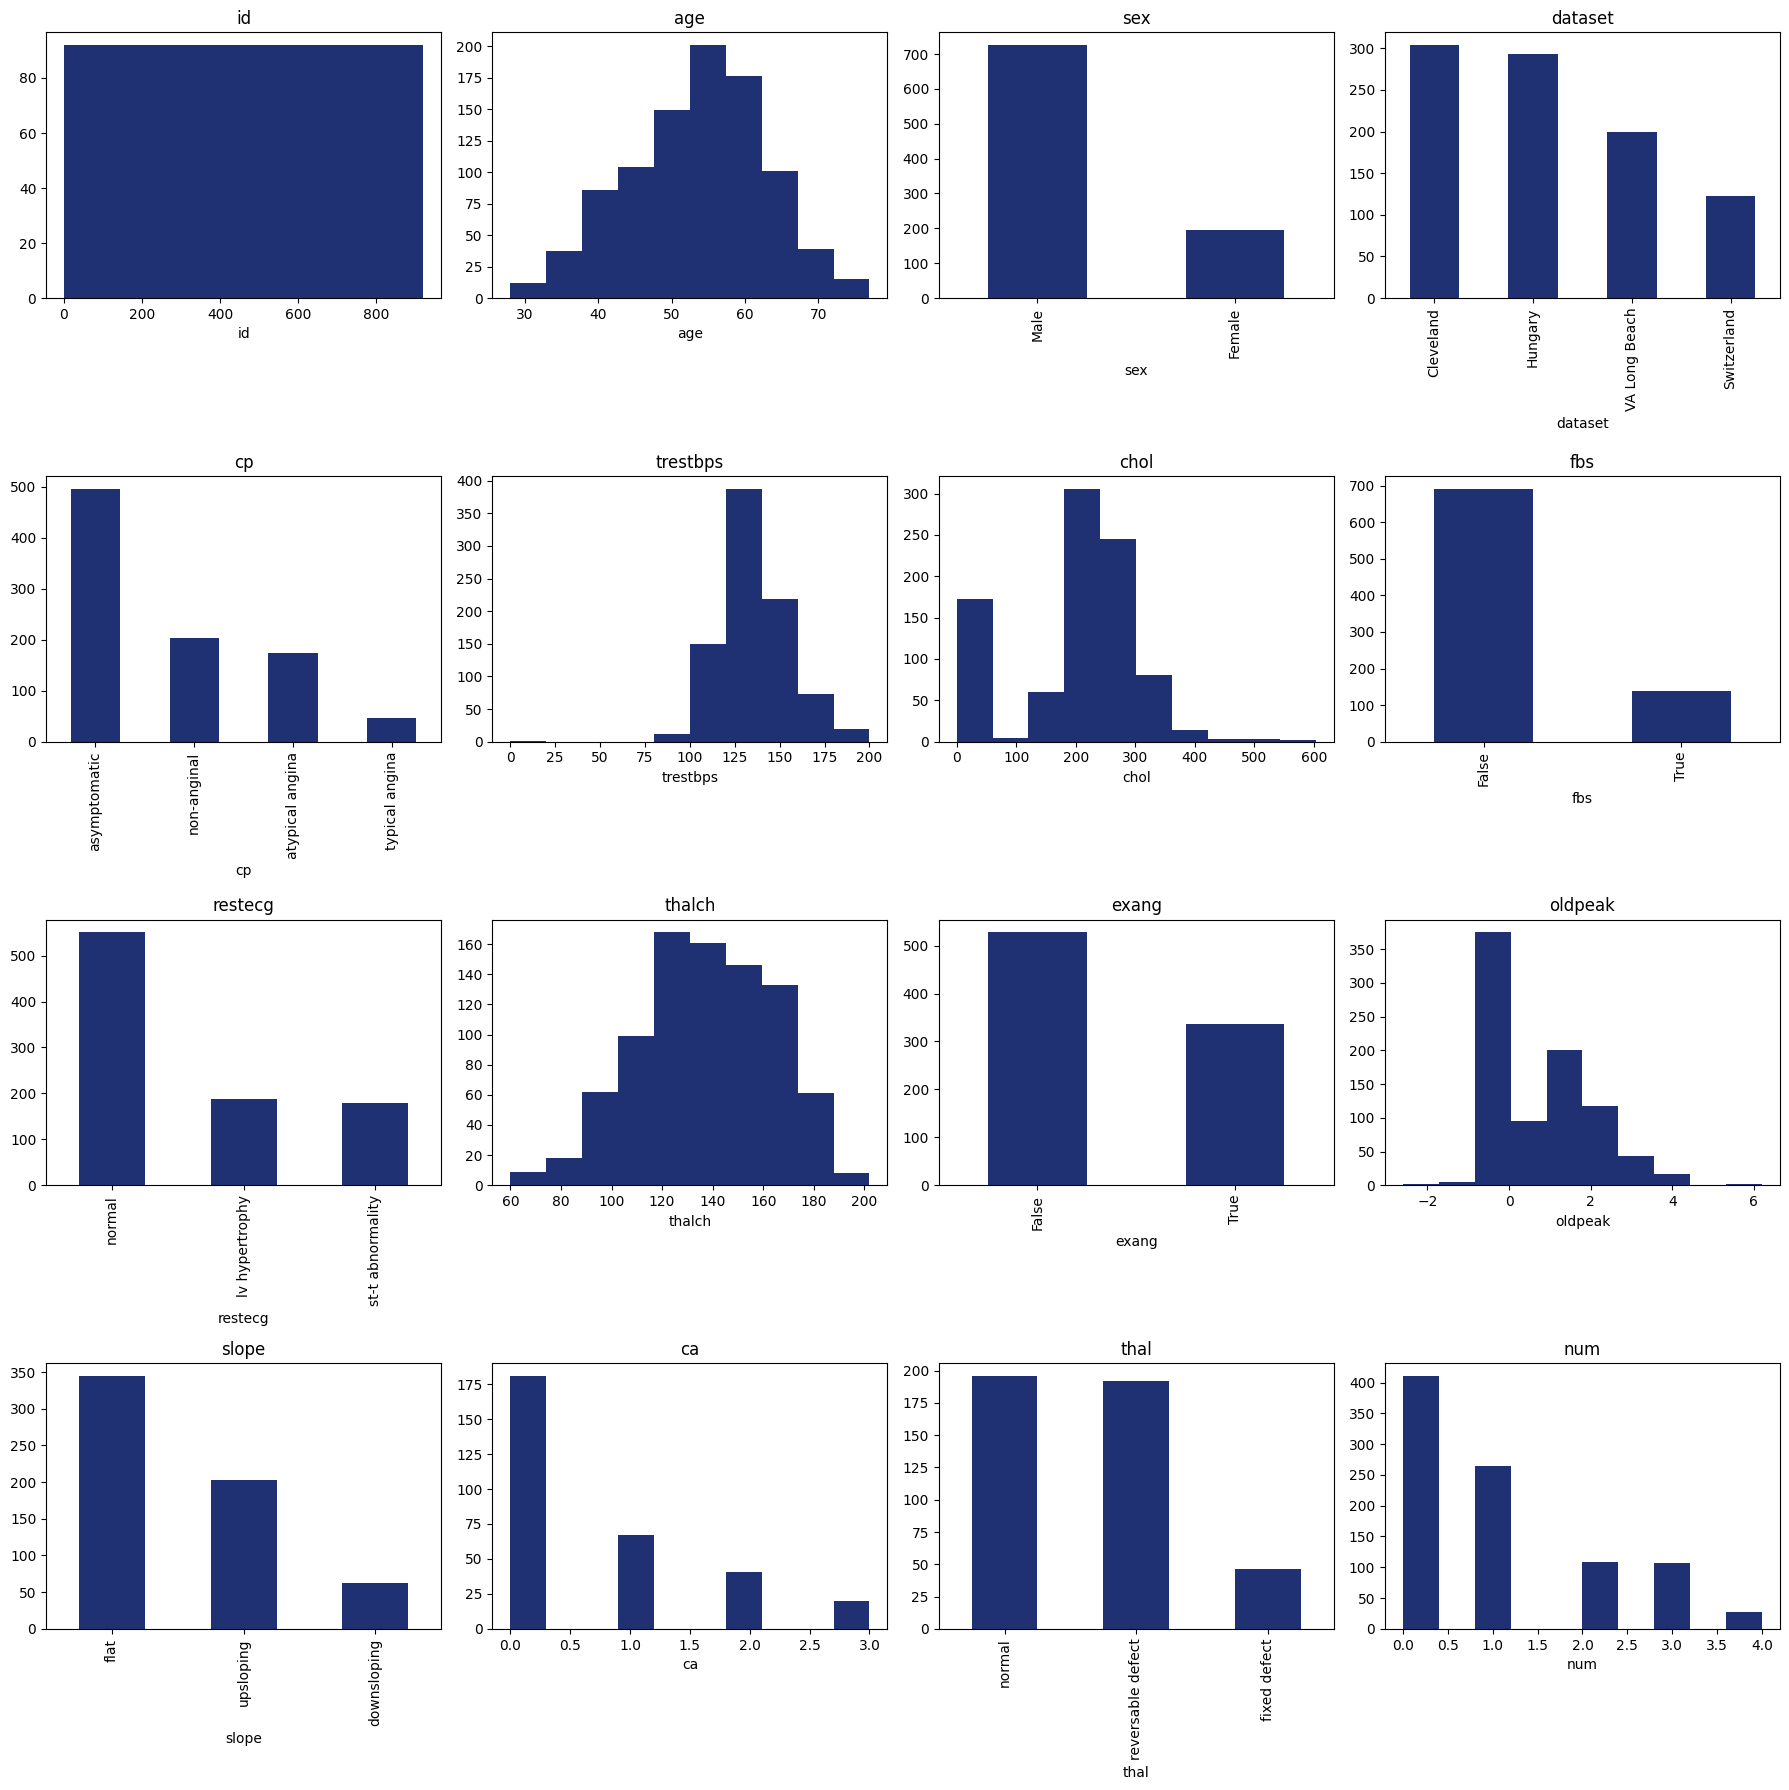

In [4]:
# prompt: plot histogram of all column in df, for categoracal columns use its label as an axis label, do 4*4 subplot with color #1f3173

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it's already defined in the preceding code.

plt.figure(figsize=(18, 18))  # Adjust figure size for a 4x4 subplot grid

for i, col in enumerate(df.columns):
  plt.subplot(4, 4, i + 1)
  if col in cat_cols:
    df[col].value_counts().plot(kind='bar', color='#1f3173')
    plt.xlabel(col)  # Use column name as x-axis label for categorical columns
  else:
      plt.hist(df[col], color='#1f3173')
      plt.xlabel(col)
  plt.title(col)
plt.tight_layout()
plt.show()


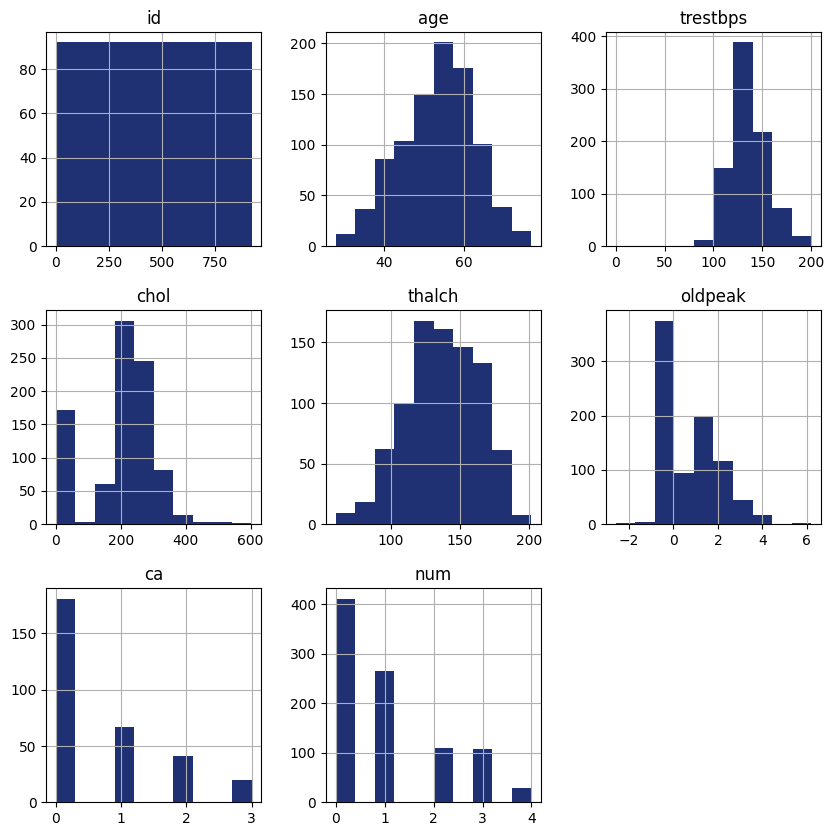

In [5]:
# plot histogram of all columns using sns
df.hist(figsize=(10, 10), color='#1f3173', alpha=1)

plt.show()

In [6]:
df.head()
# df = df.drop(columns=['id'])

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [44]:
df['ca'].unique()

array([0.  , 3.  , 2.  , 1.  , 0.15, 0.44, 0.14, 0.02, 0.25, 0.09, 0.03,
       0.26, 0.35, 0.33, 0.11, 0.05, 0.04, 0.34, 0.06, 0.01, 0.31, 0.28,
       0.61, 0.08, 0.3 , 0.27, 0.18, 0.16, 0.53, 0.54, 0.17, 0.12, 0.42,
       0.13, 0.37, 0.41, 0.46, 0.39, 0.36, 0.21, 0.48, 0.49, 0.19, 0.38,
       0.77, 0.64, 0.56, 0.47, 0.29, 0.67, 0.07, 0.23, 0.32, 0.22, 0.2 ,
       0.58, 0.43, 0.57, 0.52, 0.6 , 0.45, 0.86, 0.81, 0.24, 0.5 , 0.73,
       0.51, 0.62, 0.4 , 0.75, 1.01, 0.69, 0.83, 0.79, 0.8 , 0.55, 0.82,
       0.71, 0.85, 0.76, 0.65, 0.78, 1.03, 0.99, 0.59, 0.68, 0.94, 0.89,
       1.12, 0.93, 0.87, 0.74, 0.91, 0.63, 1.31, 0.96, 1.19, 1.27, 1.02,
       0.92, 1.29, 0.66, 1.35, 1.11, 1.09, 1.43, 1.1 , 1.16, 1.08, 1.22,
       1.44, 1.14, 1.26, 0.88, 1.32, 1.37, 0.97, 0.84, 1.33, 1.68, 1.41,
       1.49, 1.84, 1.06, 1.59, 1.23, 1.18, 1.54, 1.72, 1.53, 1.86, 1.58,
       1.05, 0.98, 1.76, 1.6 , 0.9 , 0.7 , 1.45, 1.04, 1.57, 1.2 , 1.51,
       1.21, 1.07, 1.25, 1.62, 1.47, 1.79, 1.55, 2.

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 919 entries, 0 to 919
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             919 non-null    float64
 1   age            919 non-null    float64
 2   sex            919 non-null    int64  
 3   dataset        919 non-null    int64  
 4   cp             919 non-null    int64  
 5   trestbps       919 non-null    float64
 6   chol           919 non-null    float64
 7   fbs            919 non-null    int64  
 8   restecg        919 non-null    int64  
 9   thalch         919 non-null    float64
 10  exang          919 non-null    int64  
 11  oldpeak        919 non-null    float64
 12  slope          919 non-null    int64  
 13  ca             919 non-null    float64
 14  thal           919 non-null    int64  
 15  num            919 non-null    int64  
 16  trestbps_bins  919 non-null    int64  
 17  num_bins       919 non-null    int64  
dtypes: float64(7), 

In [9]:
# @title Impute
def impute_categorical_missing_data(passed_col):

    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [col for col in missing_data_cols if col != passed_col]

    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):

    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [col for col in missing_data_cols if col != passed_col]

    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred), "\n")  # mean_squared_error
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

In [10]:
df.isnull().sum().sort_values(ascending=False)
missing_data_cols=df.isnull().sum()[df.isnull().sum()>0].index.tolist()
missing_data_cols

for cols in missing_data_cols:
    print('missing_values', cols, ':', str(round(df.isnull().sum()/len(df)*100, 2))+'%')
    if cols in cat_cols:
        df[cols] = impute_categorical_missing_data(cols)
    elif cols in numeric_cols:
        df[cols] = impute_continuous_missing_data(cols)
    else:
        pass

missing_values trestbps : id           0.00
age          0.00
sex          0.00
dataset      0.00
cp           0.00
trestbps     6.41
chol         3.26
fbs          9.78
restecg      0.22
thalch       5.98
exang        5.98
oldpeak      6.74
slope       33.59
ca          66.41
thal        52.83
num          0.00
dtype: float64%
MAE = 13.196589595375723 

RMSE = 299.3777543352601 

R2 = 0.06524601872287827 

missing_values chol : id           0.00
age          0.00
sex          0.00
dataset      0.00
cp           0.00
trestbps     0.00
chol         3.26
fbs          9.78
restecg      0.22
thalch       5.98
exang        5.98
oldpeak      6.74
slope       33.59
ca          66.41
thal        52.83
num          0.00
dtype: float64%
MAE = 45.43286516853932 

RMSE = 4125.199557865169 

R2 = 0.6732138753957164 

missing_values fbs : id           0.00
age          0.00
sex          0.00
dataset      0.00
cp           0.00
trestbps     0.00
chol         0.00
fbs          9.78
restecg      0.22
t

###feature engineering

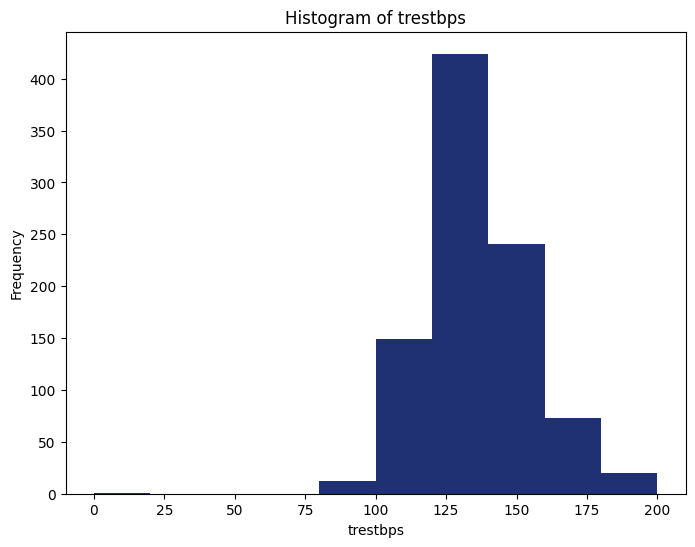

In [11]:
# prompt: plot histogram of df['trestbps']  color = #1f3173

plt.figure(figsize=(8, 6))
plt.hist(df['trestbps'], color='#1f3173')
plt.xlabel('trestbps')
plt.ylabel('Frequency')
plt.title('Histogram of trestbps')
plt.show()


In [12]:
bins=[0,60,80,130, 135, 140]
labels=['very_low', 'low','Normal', 'high', 'very_high']
df['trestbps_bins']=pd.cut(df['trestbps'], bins=bins, labels=labels)

# impute the missing values of trestos with mode
df['trestbps_bins'].fillna(df['trestbps_bins'].mode()[0], inplace=True)
df['trestbps_bins'].isnull().sum()
df.head(10)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,trestbps_bins
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,Normal
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,Normal
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,Normal
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,Normal
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,Normal
5,6,56,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0.0,normal,0,Normal
6,7,62,Female,Cleveland,asymptomatic,140.0,268.0,False,lv hypertrophy,160.0,False,3.6,downsloping,2.0,normal,3,very_high
7,8,57,Female,Cleveland,asymptomatic,120.0,354.0,False,normal,163.0,True,0.6,upsloping,0.0,normal,0,Normal
8,9,63,Male,Cleveland,asymptomatic,130.0,254.0,False,lv hypertrophy,147.0,False,1.4,flat,1.0,reversable defect,2,Normal
9,10,53,Male,Cleveland,asymptomatic,140.0,203.0,True,lv hypertrophy,155.0,True,3.1,downsloping,0.0,reversable defect,1,very_high


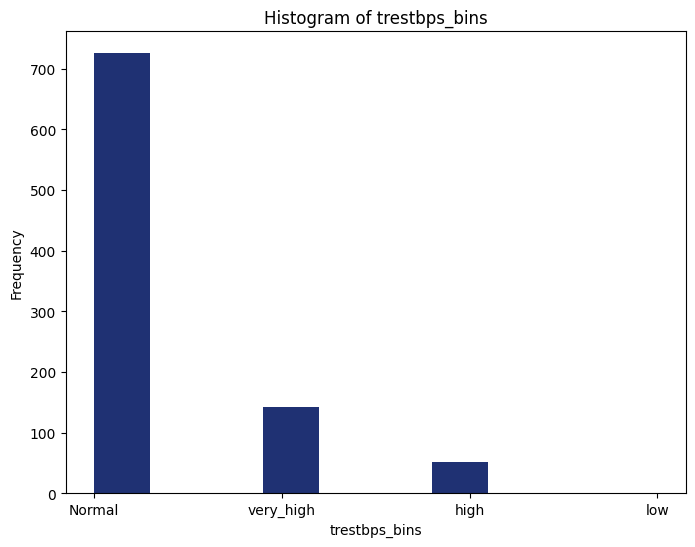

In [13]:
# prompt: plot histogram of df['trestbps_bins'] color =  #1f3173 and x axis equal to value in it

plt.figure(figsize=(8, 6))
plt.hist(df['trestbps_bins'], color='#1f3173')
plt.xlabel('trestbps_bins')
plt.ylabel('Frequency')
plt.title('Histogram of trestbps_bins')
plt.xticks(df['trestbps_bins'].unique()) #set x axis to values in column
plt.show()


In [14]:
df['restecg']=df['restecg'].apply(lambda x:x.replace(' ', '-')if ' ' in str(x) else x)

In [15]:
df['thal']=df['thal'].apply(lambda x:x.replace(' ', '-')if ' ' in str(x) else x)

In [16]:
bins=[0,1,2,3,4]
labels=['No-Heart-Disease', 'Mild-Heart-Disease', 'Moderate-Heart-Disease', 'Severe-Heart-Disease']
df['num_bins']=pd.cut(df['num'], bins=bins, labels=labels)
df['num_bins'].fillna(df['num_bins'].mode()[0], inplace=True)
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,trestbps_bins,num_bins
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv-hypertrophy,150.0,False,2.3,downsloping,0.0,fixed-defect,0,Normal,No-Heart-Disease
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv-hypertrophy,108.0,True,1.5,flat,3.0,normal,2,Normal,Mild-Heart-Disease
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv-hypertrophy,129.0,True,2.6,flat,2.0,reversable-defect,1,Normal,No-Heart-Disease
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,Normal,No-Heart-Disease
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv-hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,Normal,No-Heart-Disease


### outlier

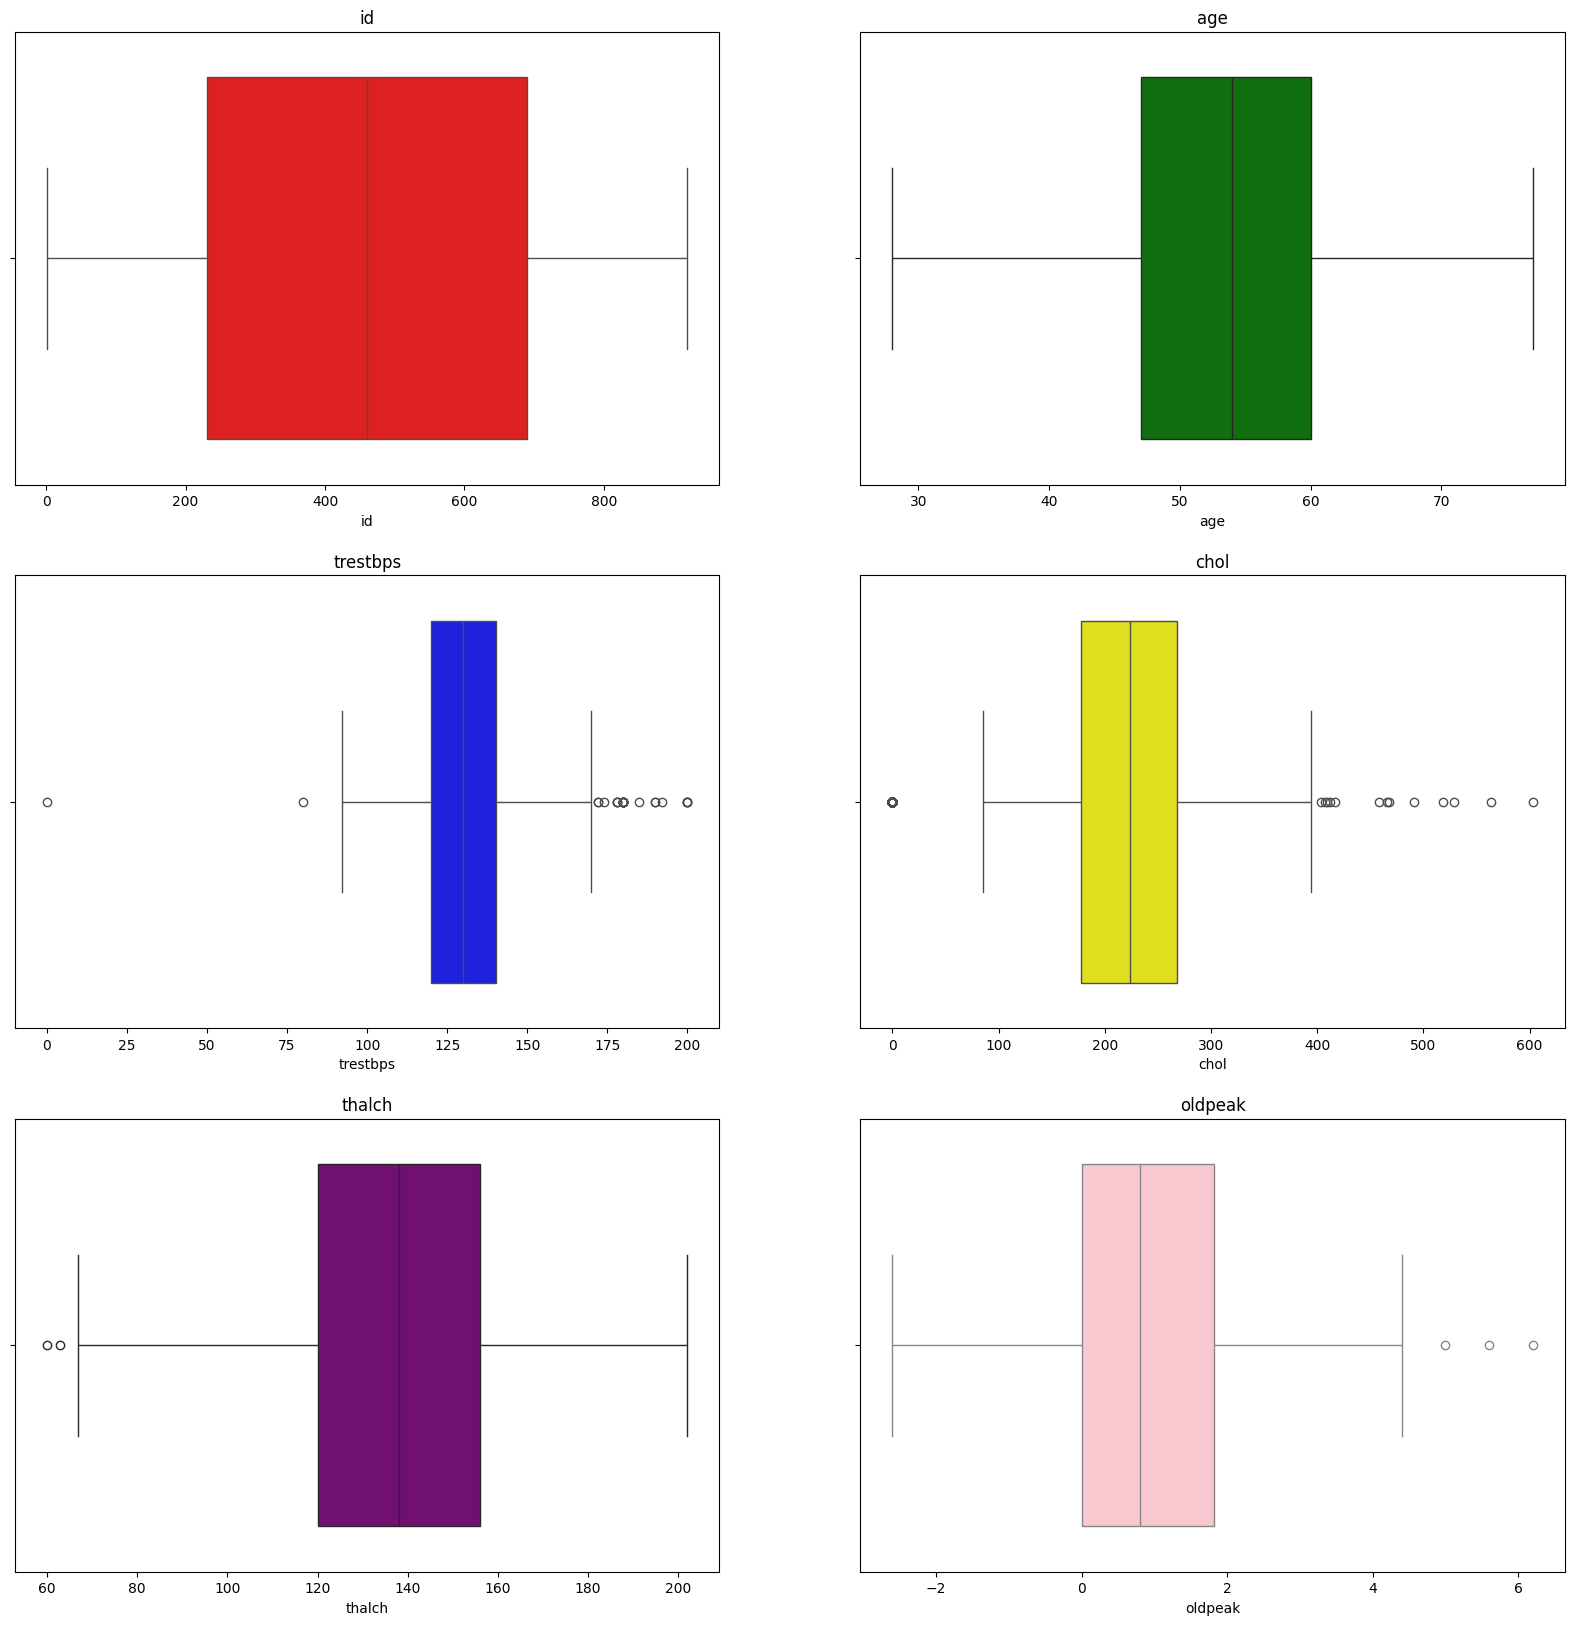

In [17]:
plt.figure(figsize=(20, 20))
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'pink']
numeric_cols = numeric_cols[:6]  # Ensure the number of columns is not more than 6
for i, col in enumerate(numeric_cols):
    ax = plt.subplot(3, 2, i + 1)
    sns.boxplot(x=df[col], color=colors[i])
    plt.title(col)
plt.show()

In [18]:
df=df[df['trestbps']!=0]

###encoding


In [19]:
# lets encode the sex column using label encoder
le_sex=LabelEncoder()
df['sex']=le_sex.fit_transform(df[['sex']])
# lets encode the dataset column using label encoder
le_dataset=LabelEncoder()
df['dataset']=le_dataset.fit_transform(df[['dataset']])
# lets encode the cp column using label encoder
le_cp=LabelEncoder()
df['cp']=le_cp.fit_transform(df[['cp']])
# lets encode the fbs column using label encoder
le_fbs=LabelEncoder()
df['fbs']=le_fbs.fit_transform(df[['fbs']])
# lets encode the trestecg column using label encoder
le_restecg=LabelEncoder()
df['restecg']=le_restecg.fit_transform(df[['restecg']])
# lets encode the exang column using label encoder
le_exang=LabelEncoder()
df['exang']=le_exang.fit_transform(df[['exang']])
# lets encode the slope column using label encoder
le_slope=LabelEncoder()
df['slope']=le_slope.fit_transform(df[['slope']])
# lets encode the thal column using label encoder
le_thal=LabelEncoder()
df['thal']=le_thal.fit_transform(df[['thal']])
# lets encode the trest_bins column using label encoder
le_trestbps_bins=LabelEncoder()
df['trestbps_bins']=le_trestbps_bins.fit_transform(df[['trestbps_bins']])
le_num_bins=LabelEncoder()
df['num_bins']=le_trestbps_bins.fit_transform(df[['num_bins']])
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,trestbps_bins,num_bins
0,1,63,1,0,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0,0,2
1,2,67,1,0,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,1,2,0,0
2,3,67,1,0,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,2,1,0,2
3,4,37,1,0,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,1,0,0,2
4,5,41,0,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,1,0,0,2


In [20]:
df2 = df.drop(columns=['num_bins'])
df2.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,trestbps_bins
0,1,63,1,0,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0,0
1,2,67,1,0,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,1,2,0
2,3,67,1,0,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,2,1,0
3,4,37,1,0,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,1,0,0
4,5,41,0,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,1,0,0


In [21]:
df2['restecg'].unique()

array([0, 1, 2])

In [22]:
# prompt: do one hot encoding to df2 in these cols cat_cols=['cp','restecg',slope','thal','trestbps_bins'] and drop 'dataset' cols

import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming df2 is defined as in your provided code

cat_cols=['cp','restecg','slope','thal','trestbps_bins']

# Create a OneHotEncoder object
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder on the categorical columns
enc.fit(df2.loc[:,['cp','restecg','slope','thal','trestbps_bins']])

# Transform the categorical features into one-hot encoded features
num_cat_features = enc.transform(df2.loc[:,['cp','restecg','slope','thal','trestbps_bins']])

# Create a new DataFrame with the one-hot encoded features
num_cat_features_df = pd.DataFrame(num_cat_features, columns=enc.get_feature_names_out(['cp','restecg','slope','thal','trestbps_bins']))

# Concatenate the one-hot encoded features with the original DataFrame
df2 = pd.concat([df2, num_cat_features_df], axis=1)

# Drop the original categorical columns and the 'dataset' column
df2 = df2.drop(columns=cat_cols+['dataset'])

df2.head()


,id,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,ca,...,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,trestbps_bins_0,trestbps_bins_1,trestbps_bins_2,trestbps_bins_3
0,1.0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2.0,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,3.0,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,4.0,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,5.0,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


###scaling

In [23]:
scalar=StandardScaler()
df[numeric_cols]=scalar.fit_transform(df[numeric_cols])

In [24]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
pt_boxcox=PowerTransformer(standardize=True)
df[numeric_cols]=pt_boxcox.fit_transform(df[numeric_cols])
pt_yeojohnson=PowerTransformer(standardize=True)
df[numeric_cols]=pt_yeojohnson.fit_transform(df[numeric_cols])
qt_normal=QuantileTransformer(output_distribution='normal', random_state=42)
df[numeric_cols]=qt_normal.fit_transform(df[numeric_cols])

In [25]:
df

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,trestbps_bins,num_bins
0,-5.199338,1.025747,1,0,3,0.803703,0.138332,1,0,0.457852,0,1.115337,0,0.00,0,0,0,2
1,-3.064732,1.498563,1,0,0,1.446104,0.967422,0,0,-1.156989,1,0.480715,1,3.00,1,2,0,0
2,-2.851066,1.498563,1,0,0,-0.688266,0.076530,0,0,-0.260967,1,1.341560,1,2.00,2,1,0,2
3,-2.719607,-1.681878,1,0,2,-0.066948,0.400955,0,1,2.377526,0,2.007821,0,0.00,1,0,0,2
4,-2.623052,-1.206386,0,0,1,-0.066948,-0.380326,0,0,1.351702,0,0.384732,2,0.00,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,2.623052,-0.036871,0,3,0,-0.287904,1.643798,1,2,0.605778,0,-0.792439,1,0.69,1,1,0,2
916,2.719607,0.885630,1,3,3,0.683085,-0.859657,0,2,-0.725069,0,0.703922,1,0.44,2,0,0,2
917,2.851066,0.087489,1,3,0,-0.457852,-0.020480,1,2,-1.379450,0,-0.792439,1,1.14,0,2,0,0
918,3.064732,0.420265,1,3,0,1.175859,2.061917,1,0,-0.843958,1,1.097710,0,0.86,2,0,0,2


In [26]:
df2 = df.drop(columns=['id', 'dataset'])
df2['target'] = df2['num']
df2 = df2.drop(columns=['num'])

df2.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,trestbps_bins,num_bins,target
0,1.025747,1,3,0.803703,0.138332,1,0,0.457852,0,1.115337,0,0.0,0,0,2,0
1,1.498563,1,0,1.446104,0.967422,0,0,-1.156989,1,0.480715,1,3.0,1,0,0,2
2,1.498563,1,0,-0.688266,0.076530,0,0,-0.260967,1,1.341560,1,2.0,2,0,2,1
3,-1.681878,1,2,-0.066948,0.400955,0,1,2.377526,0,2.007821,0,0.0,1,0,2,0
4,-1.206386,0,1,-0.066948,-0.380326,0,0,1.351702,0,0.384732,2,0.0,1,0,2,0
5,0.195098,1,1,-0.688266,0.185367,0,1,1.643798,0,0.017749,2,0.0,1,0,2,0
6,0.885630,0,0,0.502283,0.671066,0,0,0.822706,0,2.061917,0,2.0,1,3,1,3
7,0.302164,0,0,-0.688266,1.923110,0,1,0.976178,1,-0.034138,2,0.0,1,0,2,0
8,1.025747,1,0,-0.066948,0.453308,0,0,0.333758,0,0.384732,1,1.0,2,0,0,2
9,-0.150748,1,0,0.502283,-0.405398,1,0,0.647313,1,1.828076,0,0.0,2,3,2,1


##model testing

In [27]:
# @title train test split
X=df.drop(['num','num_bins'], axis=1)
y=df['num']
random_state=42

# Split the Data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42,stratify=y)

In [ ]:
# @title upsampling

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [ ]:
# @title KNN

from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import sklearn.metrics as metrics


# Step 1: Standardize the features
scaler = StandardScaler()
#x_scaled = scaler.fit_transform(x)
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)


# Step 3: Train KNN model
knn = KNeighborsClassifier(n_neighbors=3,weights='distance')
knn.fit(x_train, y_train)

# Step 4: Predict on test set
y_pred = knn.predict(x_test)

# Step 5: Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")
print("\nClassification Report:")
print(metrics.confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.62

Classification Report:
[[70  9  0  3  0]
 [11 35  7  0  0]
 [ 1  7  4  9  1]
 [ 1  8  6  6  0]
 [ 0  1  1  4  0]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        82
           1       0.58      0.66      0.62        53
           2       0.22      0.18      0.20        22
           3       0.27      0.29      0.28        21
           4       0.00      0.00      0.00         6

    accuracy                           0.62       184
   macro avg       0.38      0.40      0.39       184
weighted avg       0.60      0.62      0.61       184



In [ ]:
# @title Support Vector Machine

sc = StandardScaler()

from sklearn.svm import SVC
model1 = SVC(probability=True,C=4)



model1.fit(X_train,y_train)
rounded_predictions1 = model1.predict(X_test)
predictions1 =model1.predict_proba(X_test)
y_pred1 = rounded_predictions1

import sklearn.metrics as metrics
scores=metrics.accuracy_score(y_test,y_pred1)
print("SVM Multi-class Clasification")
print(f'accuracy: {scores}')


print(metrics.confusion_matrix(y_test,y_pred1))
print(metrics.classification_report(y_test,y_pred1))

SVM Multi-class Clasification
accuracy: 0.6739130434782609
[[71  9  0  2  0]
 [ 7 40  5  0  1]
 [ 2  5  6  9  0]
 [ 1  8  4  7  1]
 [ 0  0  1  5  0]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.87        82
           1       0.65      0.75      0.70        53
           2       0.38      0.27      0.32        22
           3       0.30      0.33      0.32        21
           4       0.00      0.00      0.00         6

    accuracy                           0.67       184
   macro avg       0.44      0.45      0.44       184
weighted avg       0.66      0.67      0.66       184



In [48]:
# prompt: train model using DT and get feature importance using feature name

from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = dt_classifier.feature_importances_

# Create a DataFrame for better visualization (optional)
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df


,Feature,Importance
0,id,0.315524
13,ca,0.265511
11,oldpeak,0.077722
9,thalch,0.076713
6,chol,0.056488
5,trestbps,0.055301
1,age,0.045651
4,cp,0.022966
14,thal,0.021469
12,slope,0.019937


In [ ]:
# @title Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

# Standardize features
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Gradient Boosting model
model1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=120, random_state=42)

# Train the model
model1.fit(X_train_scaled, y_train)

# Predict
y_pred1 = model1.predict(X_test_scaled)
predictions1 = model1.predict_proba(X_test_scaled)

# Evaluate
scores = metrics.accuracy_score(y_test, y_pred1)
print("Gradient Boosting Multi-class Classification")
print(f'accuracy: {scores}')

print(metrics.confusion_matrix(y_test, y_pred1))
print(metrics.classification_report(y_test, y_pred1))

Gradient Boosting Multi-class Classification
accuracy: 0.7228260869565217
[[73  5  2  2  0]
 [ 4 42  5  1  1]
 [ 2  2  7 11  0]
 [ 0  1  7 11  2]
 [ 0  0  2  4  0]]
              precision    recall  f1-score   support

           0       0.92      0.89      0.91        82
           1       0.84      0.79      0.82        53
           2       0.30      0.32      0.31        22
           3       0.38      0.52      0.44        21
           4       0.00      0.00      0.00         6

    accuracy                           0.72       184
   macro avg       0.49      0.50      0.49       184
weighted avg       0.73      0.72      0.73       184



In [ ]:
# @title Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=1761)

rf.fit(X_train,y_train)
rounded_predictions3 = rf.predict(X_test)
predictions3 =rf.predict_proba(X_test)
y_pred3 = rounded_predictions3


import sklearn.metrics as metrics
scores3=metrics.accuracy_score(y_test,y_pred3)
print("Random Forrest Multiclass Clasification")
print(f'accuracy: {scores3}')

print(metrics.confusion_matrix(y_test,y_pred3))
print(metrics.classification_report(y_test,y_pred3))

Random Forrest Multiclass Clasification
accuracy: 0.7880434782608695
[[76  3  2  1  0]
 [ 5 46  2  0  0]
 [ 1  3  8 10  0]
 [ 0  4  1 15  1]
 [ 0  0  1  5  0]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        82
           1       0.82      0.87      0.84        53
           2       0.57      0.36      0.44        22
           3       0.48      0.71      0.58        21
           4       0.00      0.00      0.00         6

    accuracy                           0.79       184
   macro avg       0.56      0.57      0.56       184
weighted avg       0.77      0.79      0.78       184



In [ ]:
# @title Logistic Regression
# code for LR
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

model2 =LogisticRegression(C=3)



model2.fit(X_train_scaled,y_train)

rounded_predictions2 = model2.predict(X_test_scaled)
predictions2 = model2.predict_proba(X_test_scaled)
y_pred2 = rounded_predictions2

import sklearn.metrics as metrics
scores2=metrics.accuracy_score(y_test,y_pred2)
print("LR",scores2)

print(metrics.confusion_matrix(y_test,y_pred2))
print(metrics.classification_report(y_test,y_pred2))

LR 0.6358695652173914
[[71  7  1  3  0]
 [13 33  4  3  0]
 [ 2  7  6  7  0]
 [ 0 12  2  7  0]
 [ 0  0  2  4  0]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        82
           1       0.56      0.62      0.59        53
           2       0.40      0.27      0.32        22
           3       0.29      0.33      0.31        21
           4       0.00      0.00      0.00         6

    accuracy                           0.64       184
   macro avg       0.42      0.42      0.41       184
weighted avg       0.61      0.64      0.62       184



In [ ]:
# @title AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Standardize features
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# AdaBoost model
model1 = AdaBoostClassifier(n_estimators=120, learning_rate=0.1, random_state=42)

# Train the model
model1.fit(X_train_scaled, y_train)

# Predict
y_pred1 = model1.predict(X_test_scaled)
predictions1 = model1.predict_proba(X_test_scaled)

# Evaluate
scores = metrics.accuracy_score(y_test, y_pred1)
print("AdaBoost Multi-class Classification")
print(f'accuracy: {scores}')

print(metrics.confusion_matrix(y_test, y_pred1))
print(metrics.classification_report(y_test, y_pred1))


AdaBoost Multi-class Classification
accuracy: 0.7065217391304348
[[74  5  0  3  0]
 [ 7 42  0  4  0]
 [ 2  5  0 15  0]
 [ 1  6  0 14  0]
 [ 0  0  1  5  0]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        82
           1       0.72      0.79      0.76        53
           2       0.00      0.00      0.00        22
           3       0.34      0.67      0.45        21
           4       0.00      0.00      0.00         6

    accuracy                           0.71       184
   macro avg       0.39      0.47      0.42       184
weighted avg       0.64      0.71      0.67       184



In [ ]:
# @title ANN
# code for ANN

from keras.models import Sequential
from keras import regularizers
from keras.regularizers import l2
from keras.layers import Dense ,BatchNormalization
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from tensorflow.keras.optimizers import Adam,SGD
scaler = MinMaxScaler(feature_range=(0,1))
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.src.callbacks import EarlyStopping

model4 = Sequential()

# Input + first hidden layer
model4.add(Dense(64, input_dim=16, use_bias=True, bias_initializer='zeros',
                 activation='relu', kernel_regularizer=l2(0.01)))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))

# Second hidden layer
model4.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))

# Third hidden layer
model4.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model4.add(BatchNormalization())

# Output layer
model4.add(Dense(5, activation='softmax'))
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model4.compile(loss='sparse_categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])



#Normalize train & test sample
scaled_X_train_ann=scaler.fit_transform(X_train)
scaled_X_test_ann=scaler.transform(X_test)
# Train the Model

history=model4.fit(scaled_X_train_ann, y_train,validation_split=0.1, batch_size=5,epochs=24,shuffle=True,verbose=2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


predictions4 = model4.predict(scaled_X_test_ann,batch_size=5,verbose=0)
#rounded_predictions4 = model4.predict_classes(scaled_X_test_ann,batch_size=5,verbose=0)
rounded_predictions4=np.argmax(predictions4,axis=1)
y_pred4 = rounded_predictions4


#print(predictions)
import sklearn.metrics as metrics
scores4=metrics.accuracy_score(y_test,y_pred4)
print("ANN Multi-class Clasification")
print(f'accuracy: {scores4}')

print(metrics.confusion_matrix(y_test,y_pred4))
print(metrics.classification_report(y_test,y_pred4))


Epoch 1/24
133/133 - 4s - 27ms/step - accuracy: 0.3570 - loss: 2.5431 - val_accuracy: 0.4324 - val_loss: 2.2986
Epoch 2/24
133/133 - 1s - 6ms/step - accuracy: 0.4856 - loss: 2.2014 - val_accuracy: 0.5541 - val_loss: 2.0291
Epoch 3/24
133/133 - 1s - 4ms/step - accuracy: 0.5280 - loss: 2.0954 - val_accuracy: 0.5676 - val_loss: 1.9482
Epoch 4/24
133/133 - 0s - 4ms/step - accuracy: 0.5386 - loss: 1.9734 - val_accuracy: 0.5676 - val_loss: 1.9006
Epoch 5/24
133/133 - 1s - 5ms/step - accuracy: 0.5234 - loss: 1.9271 - val_accuracy: 0.5811 - val_loss: 1.8213
Epoch 6/24
133/133 - 1s - 4ms/step - accuracy: 0.5068 - loss: 1.9088 - val_accuracy: 0.5135 - val_loss: 1.8010
Epoch 7/24
133/133 - 1s - 4ms/step - accuracy: 0.5582 - loss: 1.8013 - val_accuracy: 0.5811 - val_loss: 1.7362
Epoch 8/24
133/133 - 1s - 5ms/step - accuracy: 0.5567 - loss: 1.7676 - val_accuracy: 0.6216 - val_loss: 1.7193
Epoch 9/24
133/133 - 1s - 4ms/step - accuracy: 0.5280 - loss: 1.7779 - val_accuracy: 0.5405 - val_loss: 1.7160


In [66]:
# @title Random Forest
import random
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=4702)

rf.fit(X_train,y_train)
rounded_predictions3 = rf.predict(X_test)
predictions3 =rf.predict_proba(X_test)
y_pred3 = rounded_predictions3


import sklearn.metrics as metrics
scores3=metrics.accuracy_score(y_test,y_pred3)
print("Random Forrest Multiclass Clasification")
print(f'accuracy: {scores3}')

print(metrics.confusion_matrix(y_test,y_pred3))
print(metrics.classification_report(y_test,y_pred3))

Random Forrest Multiclass Clasification
accuracy: 0.782608695652174
[[75  4  2  1  0]
 [ 4 47  1  1  0]
 [ 1  4  8  9  0]
 [ 0  5  2 14  0]
 [ 0  0  1  5  0]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        82
           1       0.78      0.89      0.83        53
           2       0.57      0.36      0.44        22
           3       0.47      0.67      0.55        21
           4       0.00      0.00      0.00         6

    accuracy                           0.78       184
   macro avg       0.55      0.57      0.55       184
weighted avg       0.77      0.78      0.77       184

